In [3]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from scipy.stats import linregress

plt.style.use('seaborn-v0_8')


In [4]:
msd_files = sorted([x for x in os.listdir() if 'msd' in x])
n = len(msd_files)
msd_copper = msd_files[:n//2]
msd_gold = msd_files[n//2:]


msd_copper = sorted(msd_copper, key=lambda x: float(x.split('_')[-1].split('.')[0]))
msd_gold = sorted(msd_gold, key=lambda x: float(x.split('_')[-1].split('.')[0]))


Processing msd_copper_180.out and msd_gold_180.out
Processing msd_copper_300.out and msd_gold_300.out


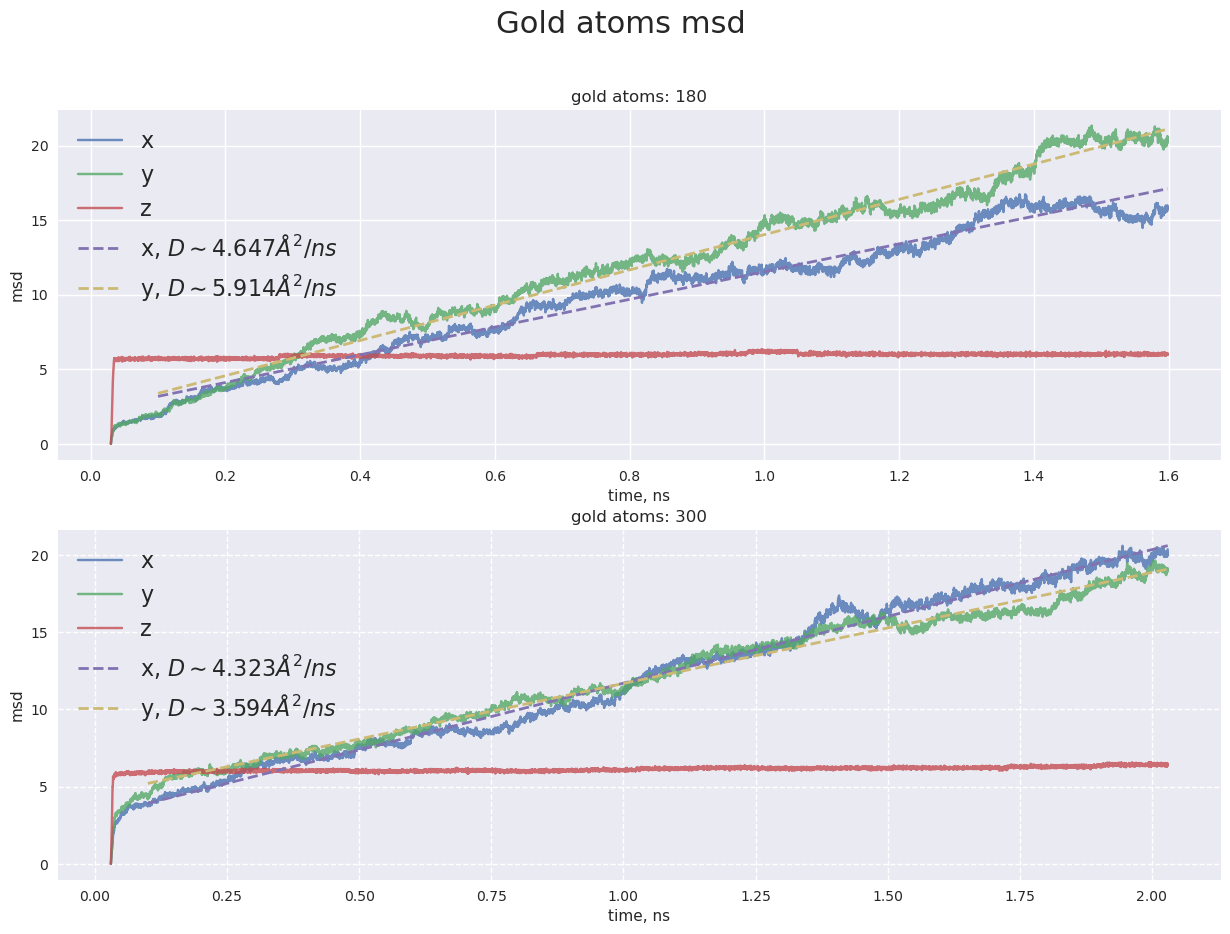

In [14]:
from scipy.stats import linregress
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(15, 10))
fig.suptitle("Gold atoms msd", fontsize=22)

Dx = []
Dy = []

for i in [6, 12]:

    msd_copper_file = msd_copper[i]
    msd_gold_file = msd_gold[i]
    ax = axs[i // 6 - 1]
    
    print(f'Processing {msd_copper_file} and {msd_gold_file}')
    
    data1 = pd.read_csv(msd_gold_file, skiprows=1, sep=' ', escapechar='#')
    data2 = pd.read_csv(msd_copper_file, skiprows=1, sep=' ', escapechar='#')
    ax.set_title(f'gold atoms: {msd_copper_file.split('_')[-1].split('.')[0]}')

    # ax.set_title(f'T = {T}, layers $\\approx$ {step // 30}', fontsize=20)
    # data1 = pd.read_csv(f'./gold/msd_gold_{T}_{step}.pos', skiprows=1, sep=' ', escapechar='#')
    # data2 = pd.read_csv(f'./gold/msd_copper_{T}_{step}.pos', skiprows=1, sep=' ', escapechar='#')
    plt.grid(True, linestyle='--')
    time = data1[' TimeStep'].astype(int) / 1e6
    ax.plot(time, data1['c_msd_gold[1]'], label='x', alpha=0.8)
    ax.plot(time, data1['c_msd_gold[2]'], label='y', alpha=0.8)
    ax.plot(time, data1['c_msd_gold[3]'], label='z', alpha=0.8)
    ax.set_xlabel('time, ns')
    ax.set_ylabel('msd')
    mask = time >= 0.1


    resx = linregress(time[mask], data1['c_msd_gold[1]'][mask])
    resy = linregress(time[mask], data1['c_msd_gold[2]'][mask])

    Dx.append(resx.slope / 2)
    Dy.append(resy.slope / 2)

    ax.plot(time[mask], time[mask] * resx.slope + resx.intercept, label=f'x, $D \\sim {resx.slope / 2:.3f}  \\AA^2/ns$', linestyle='--', linewidth=2)
    ax.plot(time[mask], time[mask] * resy.slope + resy.intercept, label=f'y, $D \\sim {resy.slope / 2:.3f}  \\AA^2/ns$', linestyle='--', linewidth=2)

    ax.legend(fontsize=16);
# plt.plot(data2[' TimeStep'], data2['c_msd_cu[1]'])

Dx = np.array(Dx)
Dy = np.array(Dy)

In [ ]:
gold_num = np.array([int(x.split('_')[-1].split('.')[0]) for x in msd_gold]) / 420

In [12]:
plt.style.available
# plt.style.use('default')
from scipy.interpolate import BSpline
from scipy.interpolate import splrep

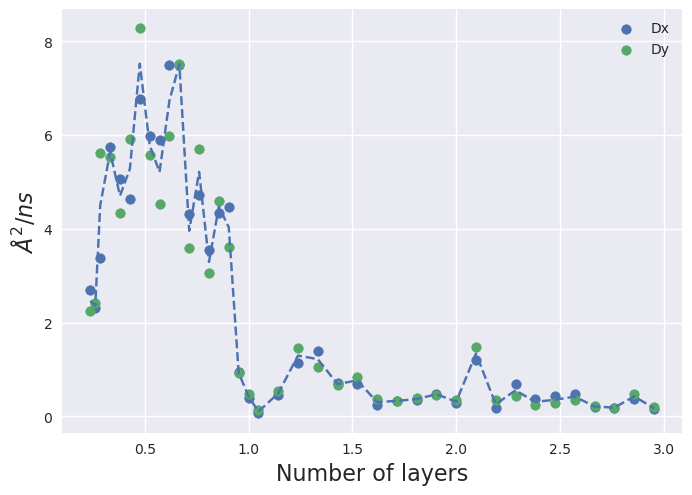

In [19]:
st = 1
plt.scatter(gold_num[st: ], Dx[st: ], label='Dx')
plt.scatter(gold_num[st: ], Dy[st: ], label='Dy')
err = abs(Dx - Dy)[st:] / 2
X = gold_num[st:]
Y = ((Dx + Dy)/2)[st:]

# t, c, k = splrep(X, Y, s=20, k=4)
# grid = np.linspace(X.min(), X.max(), 101)
# spline = BSpline(t, c, k, extrapolate=False)

# plt.figure(figsize=(10, 10))
# plt.errorbar(X, Y, yerr=None, capsize=5, capthick=1, elinewidth=1, fmt='ok')
# plt.plot(grid, spline(grid), label='spline')
plt.plot(X, Y, linestyle='--')
plt.legend();
plt.ylabel('$\\AA^2/ns$', fontsize=16)
plt.xlabel("Number of layers", fontsize=16);


In [2]:
def parse_cfg(file):

    with open(file) as f:
        add_line = False
        add_energy = False
        add_supercell = False
        add_size = False
        size = 0
        
        data = []
        frame = []
        energies = []
        supercell = []
        supercells = []
        sizes = []
        
        for line in f.readlines():
            
            
            if 'Energy'      in line: 
                add_line = False
                data.append(frame)
                frame = []
                
            if 'AtomData:'   in line:
                add_supercell = False
                supercells.append(supercell)
                supercell = []
                
                
            if add_line: 
                frame.append(list(map(float, line.split() ) ))
                
            if add_supercell:
                supercell.append(list(map(float, line.split())))    
            
            if add_energy: 
                energies.append(float(line))
                add_energy = False
                
            if add_size:
                sizes.append(float(line))
                add_size = False
            
            if 'Size'        in line: add_size = True
            if 'Energy'      in line: add_energy = True
            if 'Supercell'   in line: add_supercell = True
            if 'AtomData:'   in line: add_line = True
    
    sizes = np.array(sizes)            
    energies = np.array(energies)
    energies_per_atom = energies / sizes
    data = np.array([(np.array(x)[:, -3:] ** 2).sum() for x in data])
    supercells = np.array(supercells) 
    
    
    return (energies_per_atom, data, supercells)

energies_vasp, data_vasp, _ = parse_cfg('train.cfg')
energies_mtp, data_mtp, _ = parse_cfg('out.cfg')

In [44]:
data_vasp.shape
    

(609,)

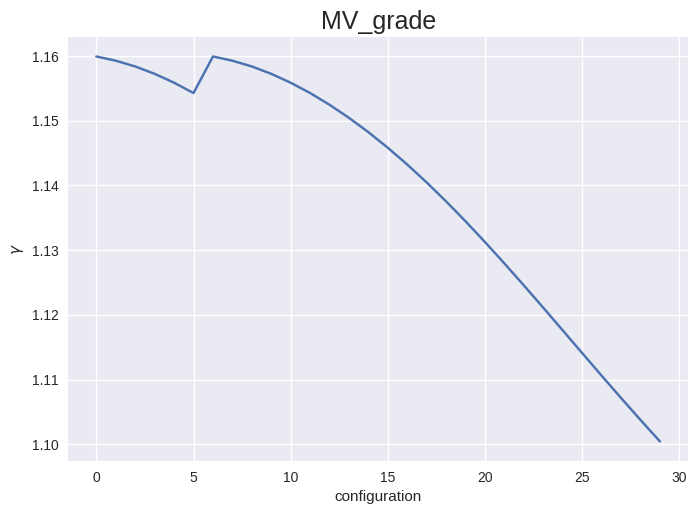

In [10]:
grades = []
with open('preselected.cfg') as f:
    for line in f.readlines():
        if "MV_grade" in line:
            grades.append(float(line.split()[-1]))
            
grades = np.array(grades)
plt.title('MV_grade', fontsize=18)
plt.ylabel('$\gamma$')
plt.xlabel('configuration')
plt.plot(grades)

In [1]:
fig, ax = plt.subplots(figsize=(16, 6))
fig.suptitle("Gold atoms msd", fontsize=22)


data1 = pd.read_csv(f'./msd_gold_30 copy.out', skiprows=1, sep=' ', escapechar='#')
data2 = pd.read_csv(f'./msd_copper_30 copy.out', skiprows=1, sep=' ', escapechar='#')

# ax.set_title(f'T = {T}, layers $\\approx$ {step // 30}', fontsize=20)
# data1 = pd.read_csv(f'./gold/msd_gold_{T}_{step}.pos', skiprows=1, sep=' ', escapechar='#')
# data2 = pd.read_csv(f'./gold/msd_copper_{T}_{step}.pos', skiprows=1, sep=' ', escapechar='#')
plt.grid(True, linestyle='--')
time = data1[' TimeStep'].astype(int) / 1e6
ax.plot(time, data1['c_msd_gold[1]'], label='x', alpha=0.8)
ax.plot(time, data1['c_msd_gold[2]'], label='y', alpha=0.8)
ax.plot(time, data1['c_msd_gold[3]'], label='z', alpha=0.8)
ax.set_xlabel('time, ns')
ax.set_ylabel('msd')
mask = time >= 0.1


resx = linregress(time[mask], data1['c_msd_gold[1]'][mask])
resy = linregress(time[mask], data1['c_msd_gold[2]'][mask])

ax.plot(time[mask], time[mask] * resx.slope + resx.intercept, label=f'x, $D \\sim {resx.slope / 2:.3f} \;\\AA^2/ns$', linestyle='--', linewidth=2)
ax.plot(time[mask], time[mask] * resy.slope + resy.intercept, label=f'y, $D \\sim {resy.slope / 2:.3f} \;\\AA^2/ns$', linestyle='--', linewidth=2)

ax.legend(fontsize=16);
# plt.plot(data2[' TimeStep'], data2['c_msd_cu[1]'])

<>:24: SyntaxWarning: invalid escape sequence '\;'
<>:25: SyntaxWarning: invalid escape sequence '\;'
<>:24: SyntaxWarning: invalid escape sequence '\;'
<>:25: SyntaxWarning: invalid escape sequence '\;'
/tmp/ipykernel_10531/3921580577.py:24: SyntaxWarning: invalid escape sequence '\;'
  ax.plot(time[mask], time[mask] * resx.slope + resx.intercept, label=f'x, $D \\sim {resx.slope / 2:.3f} \;\\AA^2/ns$', linestyle='--', linewidth=2)
/tmp/ipykernel_10531/3921580577.py:25: SyntaxWarning: invalid escape sequence '\;'
  ax.plot(time[mask], time[mask] * resy.slope + resy.intercept, label=f'y, $D \\sim {resy.slope / 2:.3f} \;\\AA^2/ns$', linestyle='--', linewidth=2)
/tmp/ipykernel_10531/3921580577.py:24: SyntaxWarning: invalid escape sequence '\;'
  ax.plot(time[mask], time[mask] * resx.slope + resx.intercept, label=f'x, $D \\sim {resx.slope / 2:.3f} \;\\AA^2/ns$', linestyle='--', linewidth=2)
/tmp/ipykernel_10531/3921580577.py:25: SyntaxWarning: invalid escape sequence '\;'
  ax.plot(time[ma

NameError: name 'plt' is not defined

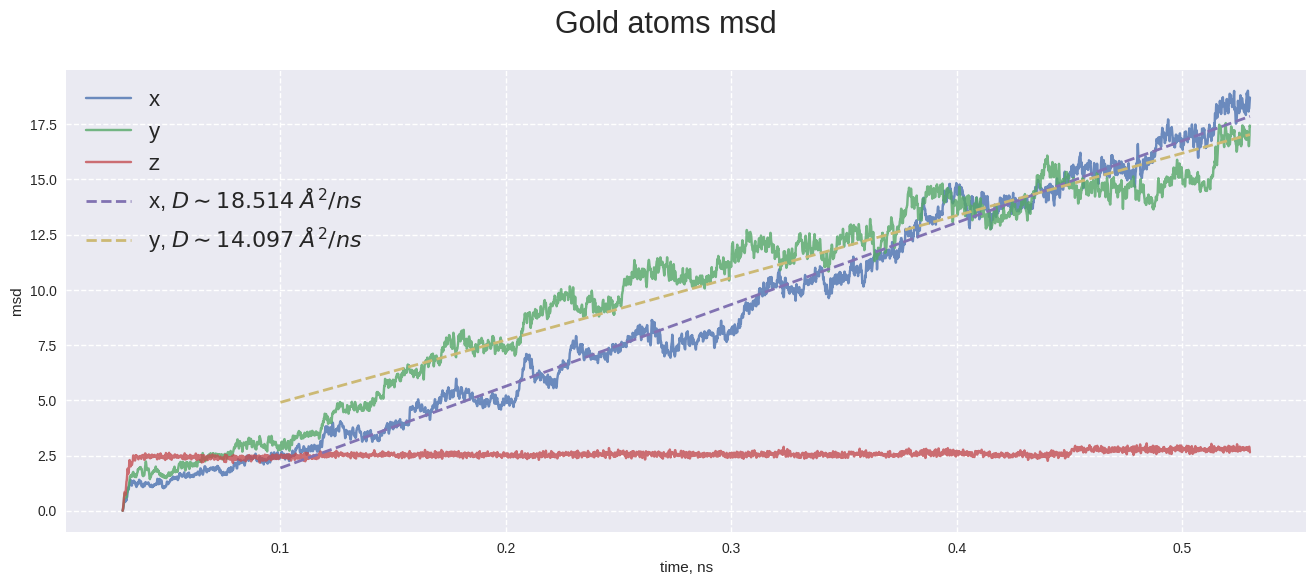

In [11]:
fig, ax = plt.subplots(figsize=(16, 6))
fig.suptitle("Gold atoms msd", fontsize=22)


data1 = pd.read_csv(f'./msd_gold_50.out', skiprows=1, sep=' ', escapechar='#')
data2 = pd.read_csv(f'./msd_copper_50.out', skiprows=1, sep=' ', escapechar='#')

# ax.set_title(f'T = {T}, layers $\\approx$ {step // 30}', fontsize=20)
# data1 = pd.read_csv(f'./gold/msd_gold_{T}_{step}.pos', skiprows=1, sep=' ', escapechar='#')
# data2 = pd.read_csv(f'./gold/msd_copper_{T}_{step}.pos', skiprows=1, sep=' ', escapechar='#')
plt.grid(True, linestyle='--')
time = data1[' TimeStep'].astype(int) / 1e6
ax.plot(time, data1['c_msd_gold[1]'], label='x', alpha=0.8)
ax.plot(time, data1['c_msd_gold[2]'], label='y', alpha=0.8)
ax.plot(time, data1['c_msd_gold[3]'], label='z', alpha=0.8)
ax.set_xlabel('time, ns')
ax.set_ylabel('msd')
mask = time >= 0.1


resx = linregress(time[mask], data1['c_msd_gold[1]'][mask])
resy = linregress(time[mask], data1['c_msd_gold[2]'][mask])

ax.plot(time[mask], time[mask] * resx.slope + resx.intercept, label=f'x, $D \\sim {resx.slope / 2:.3f} \;\\AA^2/ns$', linestyle='--', linewidth=2)
ax.plot(time[mask], time[mask] * resy.slope + resy.intercept, label=f'y, $D \\sim {resy.slope / 2:.3f} \;\\AA^2/ns$', linestyle='--', linewidth=2)

ax.legend(fontsize=16);
# plt.plot(data2[' TimeStep'], data2['c_msd_cu[1]'])

In [11]:
energies_mtp[:10], energies_vasp[:10]

(array([-214.18629388, -202.16747936, -185.18918999, -177.09349757,
        -170.70852497, -169.16876344, -170.91815025, -171.35719465,
        -171.08984352, -173.99294524]),
 array([-214.21192046, -202.19767156, -185.24320265, -177.21911181,
        -170.82400177, -169.18998786, -170.88502312, -171.29289442,
        -170.93308428, -173.72494766]))

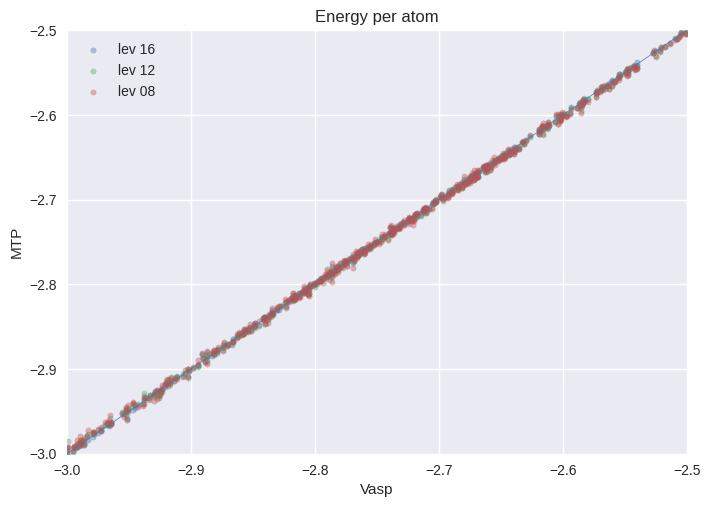

In [10]:
energies_vasp, data_vasp, _ = parse_cfg('train.cfg')

plt.plot(sorted(energies_vasp), sorted(energies_vasp), linewidth=0.5)
alpha = 0.4
energies_mtp, data_mtp, _ = parse_cfg('out.cfg')
plt.scatter(energies_vasp, energies_mtp, s=15, alpha=alpha, label='lev 16');

energies_mtp, data_mtp, _ = parse_cfg('out_12.cfg')
plt.scatter(energies_vasp, energies_mtp, s=15, alpha=alpha, label='lev 12');

energies_mtp, data_mtp, _ = parse_cfg('out_08.cfg')
plt.scatter(energies_vasp, energies_mtp, s=15, alpha=alpha, label='lev 08');

plt.title('Energy per atom')
plt.legend()
plt.ylabel('MTP')
plt.xlabel('Vasp');

from sklearn.metrics import r2_score

r2_score(energies_mtp, energies_vasp)
lims = [-3, -2.5]

plt.xlim(lims)
plt.ylim(lims);

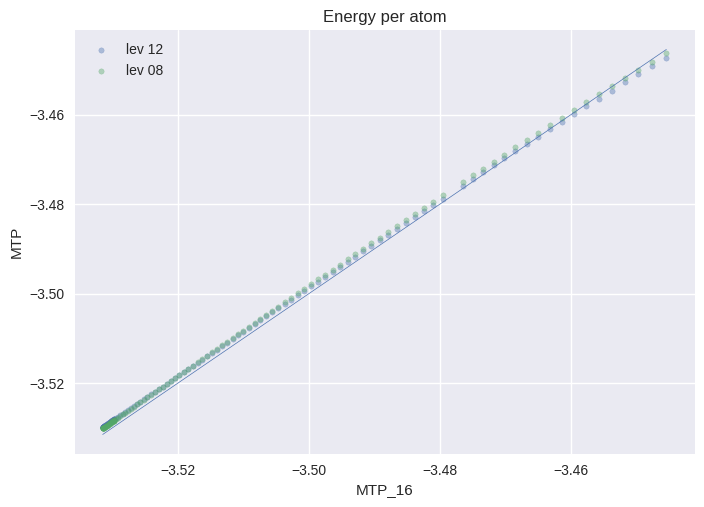

In [9]:
energies_vasp, data_vasp, _ = parse_cfg('out_16_val.cfg')

plt.plot(sorted(energies_vasp), sorted(energies_vasp), linewidth=0.5)
alpha = 0.4
# energies_mtp, data_mtp, _ = parse_cfg('out_16_val.cfg')
# plt.scatter(energies_vasp, energies_mtp, s=15, alpha=alpha, label='lev 16');

energies_mtp, data_mtp, _ = parse_cfg('out_12_val.cfg')
plt.scatter(energies_vasp, energies_mtp, s=15, alpha=alpha, label='lev 12');

energies_mtp, data_mtp, _ = parse_cfg('out_08_val.cfg')
plt.scatter(energies_vasp, energies_mtp, s=15, alpha=alpha, label='lev 08');

plt.title('Energy per atom')
plt.legend()
plt.ylabel('MTP')
plt.xlabel('MTP_16');

from sklearn.metrics import r2_score

r2_score(energies_mtp, energies_vasp)
lims = [-3, -2.5]

# plt.xlim(lims)
# plt.ylim(lims);

In [7]:
energies_vasp

array([-3.52976697, -3.52977404, -3.52979367, -3.52982565, -3.52986957,
       -3.52992488, -3.52999086, -3.53006661, -3.53015111, -3.53024318,
       -3.53034153, -3.53044474, -3.53055131, -3.53065967, -3.53076814,
       -3.53087507, -3.53097872, -3.53107737, -3.53116927, -3.53125273,
       -3.53132604, -3.53138761, -3.53143586, -3.53146929, -3.53148648,
       -3.53148612, -3.53146696, -3.53142789, -3.53136787, -3.531286  ,
       -3.53118151, -3.5310537 , -3.53090204, -3.5307261 , -3.53052554,
       -3.53030018, -3.53004992, -3.52977478, -3.52947489, -3.5291505 ,
       -3.5288019 , -3.52842954, -3.5280339 , -3.52761554, -3.52717508,
       -3.52671321, -3.5262306 , -3.52572805, -3.52520629, -3.52466609,
       -3.52410821, -3.52353342, -3.52294241, -3.52233588, -3.52171446,
       -3.52107873, -3.52042921, -3.51976633, -3.51909045, -3.51840186,
       -3.51770076, -3.51698724, -3.51626132, -3.51552299, -3.51477206,
       -3.5140083 , -3.51323144, -3.51244108, -3.5116368 , -3.51